# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [85]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the feature summary file after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(feat_info.shape)
feat_info

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [4]:
# Check the structure of the general demographics data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head(10)



(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Create a copy of demographic data to have both the original and the modified version
azdias_og = azdias.copy()

In [6]:
#see how much data is missing naturally
missing_before = azdias.isnull().sum().sum()
missing_before

4896838

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
#function that changes missing values to NaN
def makeNaN(azdias, feat_info):
    for i in range(feat_info.shape[0]):
        if feat_info['missing_or_unknown'][i] != '[]':
            
            #creating a list of values that indicate missing values, for a particular attribute
            var = feat_info['missing_or_unknown'][i].lstrip('[').rstrip(']')
            missing = var.split(',')
            
            #iterating through list to ensure integer values are type int and not str
            for count, value in enumerate(missing):
                try:
                    missing[count] = int(value)
                except:
                    True
            #replacing all missing values with NaN, for a particular attribute at a time           
            azdias[(feat_info['attribute'][i])].replace(missing, np.nan, inplace = True)
                
    return azdias

azdias = makeNaN(azdias, feat_info)

In [8]:
#Total missing data
azdias.isnull().sum().sum()

8373929

In [52]:
#save the new data set with NaN values
azdias.to_csv('azdias_missing.csv')

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

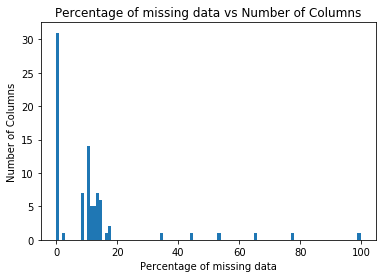

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def plot_missing(azdias):
    missing_per_column = azdias.isnull().sum()
    missing_percentage_per_column = missing_per_column/(azdias.shape[0])*100
    plt.hist(missing_percentage_per_column.values, bins = 100)
    plt.ylabel('Number of Columns')
    plt.xlabel('Percentage of missing data')
    plt.title('Percentage of missing data vs Number of Columns')
    plt.show
    
    return missing_per_column, missing_percentage_per_column

missing_per_column, missing_percentage_per_column = plot_missing(azdias)


In [10]:
# Investigate patterns in the amount of missing data in each column. These columns have a high percentage of missing values
outlier_columns = missing_percentage_per_column[missing_percentage_per_column.values > 20].index
outlier_columns


Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
def drop_outliers(azdias, outlier_columns):
    azdias = azdias.drop(outlier_columns, axis = 1)
    
    return azdias

azdias = drop_outliers(azdias, outlier_columns)



In [12]:
#confirming that columns are dropped
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

A majority of columns have missing data less than around 20 %. There are 6 columns that have a higher percentage of missing data, namely 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'. These columns are presumed to be outliers and hence are removed from the dataset

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

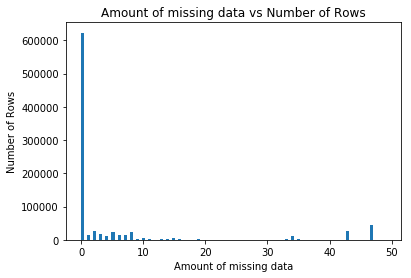

In [13]:
# How much data is missing in each row of the dataset?

def plot_missing_data_row(azdias):
    missing_per_row = azdias.isnull().sum(axis = 1)
    missing_percentage_per_row = missing_per_row/(azdias.shape[1])*100
    plt.hist(missing_per_row.values, bins = 100)
    plt.ylabel('Number of Rows')
    plt.xlabel('Amount of missing data')
    plt.title('Amount of missing data vs Number of Rows')
    plt.show
    
    return missing_per_row, missing_percentage_per_row

missing_per_row, missing_percentage_per_row = plot_missing_data_row(azdias)


In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
low_missing = missing_per_row[missing_per_row.values <=30].index
high_missing = missing_per_row[missing_per_row.values > 30].index


In [15]:
#divides data into two subsets based on missing values in each row
def split_dataset(low_missing, high_missing, azdias):
    azdias_low_missing = azdias.iloc[list(low_missing)]
    azdias_high_missing = azdias.iloc[list(high_missing)]
    
    return azdias_low_missing, azdias_high_missing

azdias_low_missing, azdias_high_missing = split_dataset(low_missing, high_missing, azdias)
print(azdias_low_missing.shape)
print(azdias_high_missing.shape)

(798067, 79)
(93154, 79)


In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# function plots data distribution for a given column in the two different datasets
def compare_distribution(azdias_low_missing, azdias_high_missing, column):
    figure, axs = plt.subplots( ncols = 2)
    sns.countplot(x = column[0], data = azdias_low_missing, ax = axs[0])
    axs[0].set_title('low missing value dataset')
    sns.countplot(x = column[0], data = azdias_high_missing, ax = axs[1])
    axs[1].set_title('high missing value dataset')
    

    
    



[['ZABEOTYP']
 ['RETOURTYP_BK_S']
 ['FINANZ_VORSORGER']
 ['FINANZ_VORSORGER']
 ['FINANZ_SPARER']]


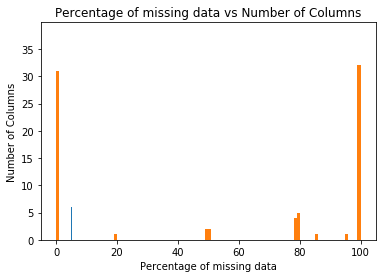

In [17]:
#choosing columns to compare between the two datasets
choose_columns_1, choose_columns_1_percent = plot_missing(azdias_low_missing)
choose_columns_2, choose_columns_2_percent = plot_missing(azdias_high_missing)

columns_1 = choose_columns_1_percent[choose_columns_1_percent.values < 5].index
columns_2 = choose_columns_2_percent[choose_columns_2_percent.values < 5].index

columns_in_both = []
for column in columns_1:
    if column in columns_2:
        columns_in_both.append(column)

        

columns_df = pd.DataFrame(columns_in_both)
columns_final = columns_df.iloc[np.random.randint(0, len(columns_in_both), size = 5)].values


print(columns_final)



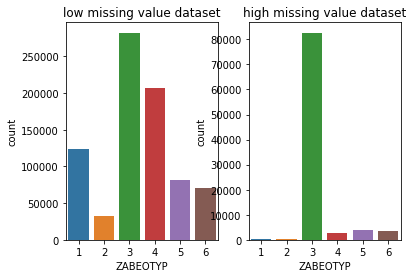

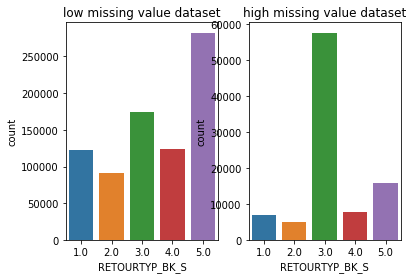

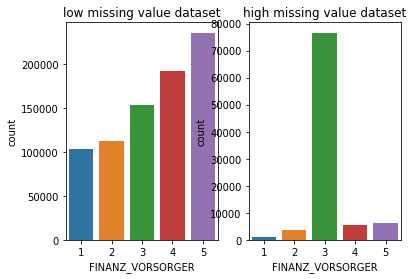

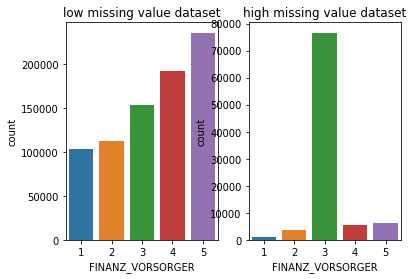

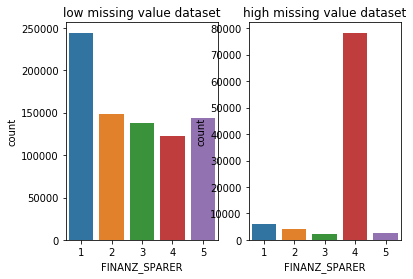

In [18]:
#plot columns for the two datasets
for column in columns_final: 
    compare_distribution(azdias_low_missing, azdias_high_missing, column)
    

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

From the graphs above it is evident that the distribution of data in columns of the rows with low amount of missing values is conisderably different than that of rows with high missing values. Hence simply ignoring one half of the data will alter our conclusions. Under ideal circumstances it will be imperative to keep both the datasets.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
def num_features(feat_info):
    num_vals = feat_info['type'].value_counts()
    
    for index, value in num_vals.items():
        print('Number of {} features is {}'.format(index, value))
    

num_features(feat_info)
        



Number of ordinal features is 49
Number of categorical features is 21
Number of numeric features is 7
Number of mixed features is 7
Number of interval features is 1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
feat_info.head(15)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def categorical(azdias_low_missing, feat_info):
    categorical_vars = feat_info.copy()
    
    #creating df only categorical variables
    for index, values in feat_info['type'].items():
        if values != 'categorical':
            categorical_vars.drop(index, axis = 0, inplace = True)
    
    #separating variables into binary and multi-level 
    binary_feat = []
    multi_feat = []
    
    for i in range(categorical_vars.shape[0]):
        try:
            if len(azdias_low_missing[categorical_vars.iloc[i]['attribute']].unique()) == 2 or (len(azdias_low_missing[categorical_vars.iloc[i]['attribute']].unique()) == 3 and 
             np.isnan(np.sum(azdias_low_missing[categorical_vars.iloc[i]['attribute']].unique()))):
                binary_feat.append(categorical_vars.iloc[i]['attribute'])
        
            else:
                multi_feat.append(categorical_vars.iloc[i]['attribute'])
        
        except:
            continue
    
    print(binary_feat)
    print(multi_feat)
    return binary_feat, multi_feat
    
        
binary_feat, multi_feat = categorical(azdias_low_missing, feat_info)


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
#figure out which binary variable needs to be remapped
def remap_binary(azdias_low_missing, binary_feat):
    for i in binary_feat:
        print(azdias_low_missing[i].unique(), i)
    
    #remapping
    try:
    azdias_low_missing['OST_WEST_KZ'] = azdias_low_missing['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    print(azdias_low_missing['OST_WEST_KZ'].value_counts())
remap_binary(azdias_low_missing, binary_feat)

[2 1] ANREDE_KZ
[0 1] GREEN_AVANTGARDE
[ 1.  0.] SOHO_KZ
[  2.   1.  nan] VERS_TYP
['W' 'O'] OST_WEST_KZ
0    629525
1    168542
Name: OST_WEST_KZ, dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Drop Variables that have more than 2 features

def drop_multi(azdias_low_missing, multi_feat):
    for feature in multi_feat:
        try:
            azdias_low_missing.drop(feature, axis = 1, inplace = True)
        except:
            continue
    
    return azdias_low_missing


azdias_low_missing = drop_multi(azdias_low_missing, multi_feat)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
azdias_low_missing.shape

(798067, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features



On initial analysis there were 21 categorical variables found. 5 of them were found to have binary data distribution, namely ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']. 13 for found to me multi level features, namely ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']. ['OST_WEST_KZ'] was found to be the binary feature that was not numerically encoded. This feature was then encoded to numerical values. The binary features, along with the newly mapped ['OST_WEST_KZ'] feature were kept in the dataset, while the multi level features for removed.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#create variable for decade
def make_dec_var(azdias_low_missing):
    azdias_low_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_low_missing['PRAEGENDE_JUGENDJAHRE'].map({int('1'): 1, int('2'):1, int('3'): 2, int('4'): 2, int('5'): 3, int('6'): 3, int('7'): 3,int('8'): 4, int('9'): 4, int('10'): 5, int('11'): 5, int('12'): 5, int('13'): 5, int('14'): 6, int('15'): 6})
    
    return azdias_low_missing
    
    
azdias_low_missing = make_dec_var(azdias_low_missing)       



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
#create variable for movement: avantgarde: 0, mainstream: 1
def make_mov_var(azdias_low_missing):
    azdias_low_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_low_missing['PRAEGENDE_JUGENDJAHRE'].map({int('1'): 1, int('2'):0, int('3'): 1, int('4'): 0, int('5'): 1, int('6'): 0, int('7'): 0,int('8'): 1, int('9'): 0, int('10'): 1, int('11'): 0, int('12'): 1, int('13'): 0, int('14'): 1, int('15'): 0})

    return azdias_low_missing

azdias_low_missing = make_mov_var(azdias_low_missing)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
#remove the PRAEGENDE_JUGENDJAHRE column
azdias_low_missing.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#make wealth variable
def make_wealth_var(azdias_low_missing):
    azdias_low_missing['CAMEO_INTL_2015_WEALTH'] = azdias_low_missing['CAMEO_INTL_2015'].map({'11':1, '12':1, '13':1, '14':1,
                                                                                                    '15':1, '21':2, '22':2, '23':2,
                                                                                                    '24':2, '25':2, '31':3, '32':3,
                                                                                                    '33':3, '34':3, '35':3, '41':4,
                                                                                                    '42':4, '43':4, '44':4, '45':4,
                                                                                                    '51':5, '52':5, '53':5, '54':5,
                                                                                                    '55':5})

    return azdias_low_missing

azdias_low_missing = make_wealth_var(azdias_low_missing)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [29]:
#make life stage variable
def make_life_stage_var(azdias_low_missing):
    azdias_low_missing['CAMEO_INTL_2015_LIFESTAGE'] = azdias_low_missing['CAMEO_INTL_2015'].map({'11':1, '12':2, '13':3, '14':4,
                                                                                                    '15':5, '21':1, '22':2, '23':3,
                                                                                                    '24':4, '25':5, '31':1, '32':2,
                                                                                                    '33':3, '34':4, '35':5, '41':1,
                                                                                                    '42':2, '43':3, '44':4, '45':5,
                                                                                                    '51':1, '52':2, '53':3, '54':4,
                                                                                                    '55':5})

    return azdias_low_missing

azdias_low_missing = make_life_stage_var(azdias_low_missing)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
#remove the CAMEO_INTL_2015 column
azdias_low_missing.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [31]:
azdias_low_missing.shape

(798067, 68)

In [32]:
def drop_mix_col(azdias_low_missing, feat_info):
    
    mixed_columns = []
    #creating list of other mixxed variables
    for index, values in feat_info['type'].items():
        if values == 'mixed' and feat_info.iloc[index]['attribute'] != 'PRAEGENDE_JUGENDJAHRE' and feat_info.iloc[index]['attribute'] != 'CAMEO_INTL_2015':
            mixed_columns.append(feat_info.iloc[index]['attribute'])
            
    #drop other mixed variables
    for column in mixed_columns:
        try:
            azdias_low_missing.drop(column, axis = 1, inplace = True)
        except:
            continue
     
    return azdias_low_missing
    
azdias_low_missing = drop_mix_col(azdias_low_missing, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
azdias_low_missing.shape

(798067, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features


Two new columns were formed to account for the decade as well as movement in PRAEGENDE_JUGENDJAHRE column. Values in the two new columns were mapped accordingly, based on instructions. The original PRAEGENDE_JUGENDJAHRE was then dropped from the dataset.

Similarly two new columns were also formed to account for the wealth as well as life stage in the CAMEO_INTL_2015 variable. Values were mapped accordingly and the orginial CAMEO_INTL_2015 was dropped from the dataset.

The remianining 'mixed' variable columns were also dropped from the dataset



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_low_missing.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [76]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_NaN = makeNaN(df, feat_info)
    
    
    # remove selected columns and rows, ...
    #for column
    customer_missing_per_column, customer_missing_percentage_per_column = plot_missing(df_NaN)
    #remove columns with more than 35% NaN
    customer_outlier_columns = customer_missing_percentage_per_column[customer_missing_percentage_per_column.values > 35].index
    df_rem_col = drop_outliers(df_NaN, customer_outlier_columns)
    
    #for rows
    customer_missing_per_row, customer_missing_percentage_per_row = plot_missing_data_row(df_rem_col)
    customer_low_missing = customer_missing_per_row[customer_missing_per_row.values <=30].index
    customer_high_missing = customer_missing_per_row[customer_missing_per_row.values > 30].index
    df_low_missing, df_high_missing = split_dataset(customer_low_missing, customer_high_missing, df_rem_col)
    
    # select, re-encode, and engineer column values.
    #Encode non numeric binary feature
    customer_binary_feat, customer_multi_feat = categorical(df_low_missing, feat_info)
    remap_binary(df_low_missing, customer_binary_feat)
    
    #drop multi-feature categorical variables
    df_low_missing = drop_multi(df_low_missing, customer_multi_feat)
    
    #Rencoding mixed variables
    df_low_missing = make_dec_var(df_low_missing)
    df_low_missing = make_mov_var(df_low_missing)
    
    #remove the PRAEGENDE_JUGENDJAHRE column
    df_low_missing.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    
    #Rencoding mixed variables
    df_low_missing = make_wealth_var(df_low_missing)
    df_low_missing = make_life_stage_var(df_low_missing)
    
    #remove the CAMEO_INTL_2015 column
    df_low_missing.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
    
    #drop remaining mixed variable columns
    df_low_missing = drop_mix_col(df_low_missing, feat_info)



    
    # Return the cleaned dataframe.
    return df_low_missing
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
def use_impute(azdias_low_missing):
    imp = Imputer(missing_values = np.nan, strategy = 'most_frequent', axis = 0)
    azdias_clean = pd.DataFrame(imp.fit_transform(azdias_low_missing))
    return azdias_clean


In [94]:
#Use imputer to fill in NaN values
def clean(azdias_low_missing):
    azdias_clean = use_impute(azdias_low_missing)
    azdias_clean.columns = azdias_low_missing.columns
    azdias_clean.index = azdias_low_missing.index
    return azdias_clean

azdias_clean = clean(azdias_low_missing)

In [95]:
# Apply feature scaling to the general population demographics data.
def feat_scale(azdias_clean):
    scaler = p.StandardScaler()
    azdias_standard = pd.DataFrame(scaler.fit_transform(azdias_clean))
    azdias_standard.columns = azdias_low_missing.columns
    azdias_standard.index = azdias_low_missing.index
    return azdias_standard, scaler


azdias_standard, scaler= feat_scale(azdias_clean)

In [96]:
azdias_standard.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,-1.766647,0.957912,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,-0.530407,1.010156,...,0.442535,1.455855,0.574309,-0.171399,-0.127042,0.684885,1.098064,0.530407,1.175655,-1.248888
2,0.200522,0.957912,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.885345,1.010156,...,-0.934791,0.419746,0.574309,-0.171399,-0.127042,-0.789025,1.098064,-1.885345,-0.869682,0.767097
3,1.184107,0.957912,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.311824,...,-0.934791,-0.616363,0.574309,-1.173149,-0.997550,-0.052070,-0.267784,0.530407,-1.551461,-0.576893
4,0.200522,-1.043937,0.683145,0.191200,0.411886,-1.249987,0.244109,-0.791197,-0.530407,1.010156,...,0.442535,-0.616363,-0.337194,0.830351,0.308212,1.421840,-0.267784,0.530407,0.493876,0.095102
5,-1.766647,0.957912,-0.042768,-1.155519,1.138172,-0.570999,-0.470414,1.339319,-0.530407,1.010156,...,0.442535,1.455855,1.485812,-1.173149,-0.997550,-0.052070,-1.633632,0.530407,1.175655,0.767097


### Discussion 2.1: Apply Feature Scaling

Imputer was used to fill NaN values in the dataset and then StandardScaler was used to Standardize the dataset


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
def do_pca(n_components, data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    
    return pca, X_pca



In [41]:
pca, X_pca = do_pca(33, azdias_standard)

In [42]:
X_pca.shape

(798067, 33)

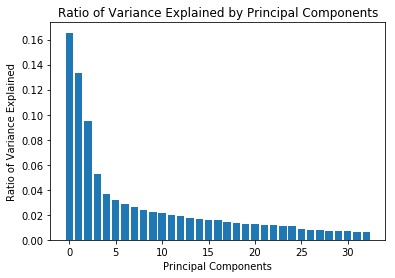

In [43]:
# Investigate the variance accounted for by each principal component.
#plot variance explained ratio
def var_ratio_plot(pca):
    plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.xlabel('Principal Components')
    plt.ylabel('Ratio of Variance Explained')
    plt.title('Ratio of Variance Explained by Principal Components')
    plt.show()

var_ratio_plot(pca)


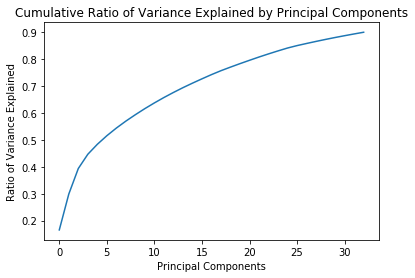

In [44]:
#Plot Cumulative variance explained
def cum_var_ratio_plot(pca):
    plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Principal Components')
    plt.ylabel('Ratio of Variance Explained')
    plt.title('Cumulative Ratio of Variance Explained by Principal Components')
    plt.show()

cum_var_ratio_plot(pca)

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(33, azdias_standard)

In [46]:
azdias_aft_pca = pd.DataFrame(X_pca)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to keep 33 principal components as they explained the variance of around 90% of the dataset and almost halved the number of columns

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [47]:
#function maps weights for principal components
def map_weight(pca, component, azdias_standard):
    x = pd.DataFrame(pca.components_, columns = azdias_standard.columns)
    weights = x.iloc[component].sort_values(ascending = False)
    return weights

  

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
weights_1 =  map_weight(pca, 0, azdias_standard)
print(weights_1)


PLZ8_ANTG3                        0.225345
PLZ8_ANTG4                        0.216872
CAMEO_INTL_2015_WEALTH            0.204627
HH_EINKOMMEN_SCORE                0.202187
ORTSGR_KLS9                       0.196765
EWDICHTE                          0.194654
FINANZ_HAUSBAUER                  0.159509
KBA05_ANTG4                       0.153988
PLZ8_ANTG2                        0.153685
FINANZ_SPARER                     0.153110
ARBEIT                            0.142565
KBA05_ANTG3                       0.136723
ANZ_HAUSHALTE_AKTIV               0.136056
RELAT_AB                          0.134948
SEMIO_PFLICHT                     0.121171
SEMIO_REL                         0.118599
PRAEGENDE_JUGENDJAHRE_DECADE      0.112257
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.110213
SEMIO_RAT                         0.099581
SEMIO_TRADV                       0.093724
SEMIO_MAT                         0.082443
FINANZ_UNAUFFAELLIGER             0.081094
SEMIO_FAM                         0.081011
SEMIO_KULT 

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_2 =  map_weight(pca, 1, azdias_standard)
print(weights_2)



ALTERSKATEGORIE_GROB              0.256265
SEMIO_ERL                         0.229916
FINANZ_VORSORGER                  0.229239
SEMIO_LUST                        0.180110
RETOURTYP_BK_S                    0.161876
FINANZ_HAUSBAUER                  0.121831
SEMIO_KRIT                        0.117849
SEMIO_KAEM                        0.116437
W_KEIT_KIND_HH                    0.114739
PLZ8_ANTG3                        0.098404
EWDICHTE                          0.097909
ORTSGR_KLS9                       0.096589
PLZ8_ANTG4                        0.096258
ANREDE_KZ                         0.093140
CAMEO_INTL_2015_WEALTH            0.079219
KBA05_ANTG4                       0.075240
SEMIO_DOM                         0.074492
ARBEIT                            0.071835
RELAT_AB                          0.069308
PLZ8_ANTG2                        0.068172
ANZ_HAUSHALTE_AKTIV               0.066490
HH_EINKOMMEN_SCORE                0.061968
FINANZ_MINIMALIST                 0.059374
WOHNDAUER_2

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_3 =  map_weight(pca, 2, azdias_standard)
print(weights_3)



SEMIO_VERT                        0.344663
SEMIO_SOZ                         0.261933
SEMIO_FAM                         0.248836
SEMIO_KULT                        0.233937
FINANZ_MINIMALIST                 0.154492
RETOURTYP_BK_S                    0.108973
FINANZ_VORSORGER                  0.101711
W_KEIT_KIND_HH                    0.085079
ALTERSKATEGORIE_GROB              0.079615
SEMIO_REL                         0.067672
SEMIO_LUST                        0.064451
SEMIO_MAT                         0.055671
ORTSGR_KLS9                       0.050284
EWDICHTE                          0.049493
PLZ8_ANTG4                        0.049208
PLZ8_ANTG3                        0.048411
GREEN_AVANTGARDE                  0.047104
ARBEIT                            0.037364
RELAT_AB                          0.034365
PLZ8_ANTG2                        0.032675
WOHNDAUER_2008                    0.032651
CAMEO_INTL_2015_WEALTH            0.030184
KBA05_ANTG4                       0.029999
ANZ_HAUSHAL

### Discussion 2.3: Interpret Principal Components




Component 1: For the first component, the highest weighted features were PLZ8_ANTG3, PLZ8_ANTG4, CAMEO_INTL_2015_WEALTH and HH_EINKOMMEN_SCORE with weights of 0.225345, 0.216872, 0.204627, 0.202187 respectively. PLZ8_ANTG3, PLZ8_ANTG4 relate to large family sizes, exceeding 6 people, in the PLZ8 area. CAMEO_INTL_2015_WEALTH relates to the wealth of a household while HH_EINKOMMEN_SCORE relates to net income. It makes sense that these features are correlated since large families tend to have a higher net income and hence are more wealthy. The highest negatively weighted features were FINANZ_MINIMALIST, MOBI_REGIO and PLZ8_ANTG1 with weights of -0.223093, -0.224811 and -0.225665 respectively. It makes sense that these features are negatively correlated to the the previously mentioned features as these refer more to financial minimalism, mobility and small family sizes, while the previosuly mentioned onces referred to the opposite, large family sizes and wealthy households

Component 2: For the second component, the highest weighted features were ALTERSKATEGORIE_GROB, SEMIO_ERL and FINANZ_VORSORGER with weights of 0.256265, 0.229916 and 0.229239 respectively. ALTERSKATEGORIE_GROB refers to age, SEMIO_ERL refers to personality typology, a person that is event oriented and FINANZ_VORSORGER refers to financial typlogy, individuals who are always prepared int terms of monetary needs. The correlation between these is interesting as it indicates that not only does a persons personality and financial strategy depend on their age, their personality also comes across in their financial strategy. The highest negatively weighted features were FINANZ_SPARER, PRAEGENDE_JUGENDJAHRE_DECADE and SEMIO_REL with weights of, -0.231660, -0.238552 and -0.253635 respectively. PRAEGENDE_JUGENDJAHRE_DECADE indicates which decade an indiviual were a youth in and the dominant movement of the time, FINANZ_SPARER refers to individuals who save money and SEMIO_REL refers to a religious individuals. The negative correlation between these features and the previously mentioned ones is not intuitively apparent.

Component 3: For the third component, the highest weighted features were SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT with weights of 0.344663, 0.261933, 0.248836, 0.233937 respectively.All of these features refer to personality typology. They encompass individuals who are family-minded, socially minded, culturally minded and dreamful. These correlations are apparent and make sense. The highest negative weighted features were SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ with weights of -0.313070, -0.335050, -0.367353 respectively. SEMIO_DOM, SEMIO_KAEM refer to dominant and combative minded individuals and it makes sense these are negatively correlated to the previously mentioned, socially minded and family minded features as those qualities are opposites.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
#function determines score of a particular model
def do_kmeans(num_clusters, data):
    our_kmeans = KMeans(n_clusters = num_clusters)
    model = our_kmeans.fit(data)
    return np.abs(model.score(data))
    
    

In [56]:
#try out different rumber of clusters
scores=[]
for i in range(2,26):
    scores.append(do_kmeans(i, X_pca))

print(scores)

[39612313.820534833, 36307764.121821128, 34242116.620302156, 32746848.261941101, 31516205.395313744, 30371021.294478334, 29531213.752202678, 28929298.766324755, 28168163.449788526, 27515994.099783607, 27193208.00521525, 26734522.311281417, 26411599.776048481, 26288008.789670207, 25692662.198743429, 25514939.228142429, 25333569.093381453, 24656633.581805684, 24475674.204820007, 24272306.119149778, 23897357.28134397, 23801734.941430796, 23689210.21575997, 23302381.527421951]


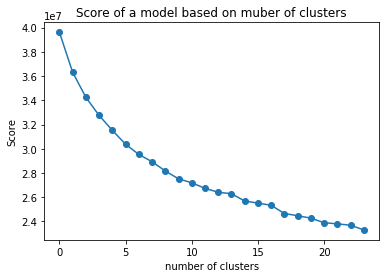

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(len(scores)), scores, marker = 'o')
plt.xlabel('number of clusters')
plt.ylabel('Score')
plt.title('Score of a model based on muber of clusters')
plt.show()


In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
our_kmeans = KMeans(n_clusters = 17)
model = our_kmeans.fit(X_pca)
azdias_pred = model.predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

Plotting the scores obtained from running the Kmeans algorithm on a number of different clusters shows that at around n_clusters = 17 the score starts to level out. Hence based on the elbow method I chose the number of clusters to be 17

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [97]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [98]:
customers.shape

(191652, 85)

In [67]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
[1 2] ANREDE_KZ
[1 0] GREEN_AVANTGARDE
[ 0.  1.] SOHO_KZ
[  1.   2.  nan] VERS_TYP
['W' 'O'] OST_WEST_KZ


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0    130382
1     11343
Name: OST_WEST_KZ, dtype: int64


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

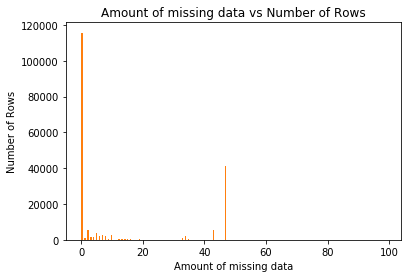

In [99]:
#applying preprocessing to the customer df via the clean_data function
customers = clean_data(customers, feat_info)

In [100]:
customers.shape

(141725, 64)

In [101]:
#fill NaN values using Imputer
customers = clean(customers)

In [102]:
#feature scaling
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [103]:
customers.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.184107,-1.043937,1.409058,-1.155519,1.138172,-1.249987,-0.470414,-0.791197,1.885345,-1.633804,...,-0.934791,1.455855,1.485812,-2.174899,-1.432804,-1.525981,-1.633632,-1.885345,-1.551461,0.095102
1,1.184107,0.957912,1.409058,-1.155519,1.138172,-1.249987,0.958633,0.629147,1.885345,-0.311824,...,0.442535,-0.616363,-1.248696,-0.171399,-0.127042,-0.052070,-1.633632,-1.885345,-0.187903,0.767097
2,1.184107,-1.043937,1.409058,-1.155519,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.311824,...,-0.934791,-0.616363,0.574309,-2.174899,-0.997550,-1.525981,-2.316556,0.530407,-0.869682,0.767097
3,0.200522,-1.043937,-0.042768,-1.155519,0.411886,0.786977,1.673157,-0.791197,-0.530407,1.010156,...,0.442535,-0.616363,-0.337194,-0.171399,-0.127042,-1.525981,-0.267784,0.530407,0.493876,-1.248888
4,0.200522,-1.043937,1.409058,-1.155519,1.138172,-1.249987,-0.470414,-0.081025,1.885345,1.010156,...,0.442535,1.455855,1.485812,-0.171399,0.743466,1.421840,-1.633632,-1.885345,-0.187903,0.767097


In [104]:
#apply pca
customers_pca = pca.transform(customers)

In [105]:
#apply KMEANS
customers_pred = model.predict(customers_pca)



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Number of people in Customer cluster')

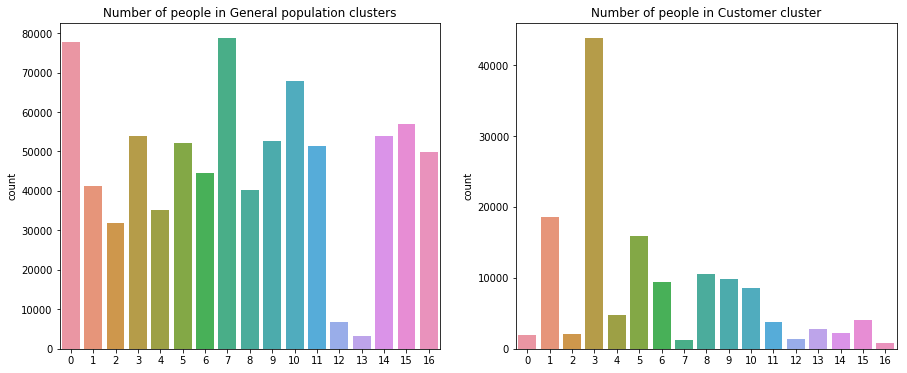

In [110]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots( ncols = 2, figsize = (15,6))
sns.countplot(azdias_pred, ax = axs[0])
axs[0].set_title('Number of people in General population clusters')
sns.countplot(customers_pred, ax = axs[1])
axs[1].set_title('Number of people in Customer cluster')


In [111]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_rep = scaler.inverse_transform(pca.inverse_transform((model.cluster_centers_[3])))


In [121]:
#Discarded data comparison
gen_pop_discard = azdias_og.shape[0]-azdias_low_missing.shape[0]
customer_pop_discard = 191652-customers.shape[0]
ratio_gen_discard = gen_pop_discard/azdias_low_missing.shape[0]
ratio_customer_discard = customer_pop_discard/customers.shape[0]
print(ratio_gen_discard)
print(ratio_customer_discard)

0.11672453565928675
0.3522808255424237


In [118]:
over_rep_column = pd.Series(data = over_rep, index = azdias_low_missing.columns)
print(over_rep_column.sort_values(ascending = False))


MIN_GEBAEUDEJAHR                  1992.957314
KBA13_ANZAHL_PKW                   700.379047
WOHNDAUER_2008                       8.479246
SEMIO_VERT                           6.255302
ORTSGR_KLS9                          5.409498
SEMIO_LUST                           5.247020
SEMIO_KULT                           4.886968
SEMIO_SOZ                            4.850129
FINANZ_MINIMALIST                    4.850088
SEMIO_FAM                            4.845092
INNENSTADT                           4.507501
W_KEIT_KIND_HH                       4.215334
FINANZ_VORSORGER                     4.211768
SEMIO_ERL                            4.095981
KBA05_GBZ                            4.065130
MOBI_REGIO                           4.062931
BALLRAUM                             4.022103
EWDICHTE                             4.018716
RETOURTYP_BK_S                       4.005483
SEMIO_MAT                            3.964771
GEBAEUDETYP_RASTER                   3.950703
PLZ8_GBZ                          

In [122]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_rep = scaler.inverse_transform(pca.inverse_transform((model.cluster_centers_[7])))
under_rep_column = pd.Series(data = under_rep, index = azdias_low_missing.columns)
print(under_rep_column.sort_values(ascending = False))


MIN_GEBAEUDEJAHR                  1992.481092
KBA13_ANZAHL_PKW                   531.692231
ANZ_HAUSHALTE_AKTIV                 12.901972
WOHNDAUER_2008                       7.261209
ORTSGR_KLS9                          6.942587
SEMIO_PFLICHT                        6.280976
SEMIO_RAT                            6.222042
SEMIO_DOM                            6.169574
SEMIO_KAEM                           6.133526
PRAEGENDE_JUGENDJAHRE_DECADE         5.694466
SEMIO_TRADV                          5.642790
HH_EINKOMMEN_SCORE                   5.583730
SEMIO_KRIT                           5.487009
SEMIO_REL                            5.442742
EWDICHTE                             5.179223
REGIOTYP                             5.051746
SEMIO_MAT                            5.006290
CAMEO_INTL_2015_WEALTH               4.312084
FINANZ_SPARER                        4.297062
SEMIO_ERL                            4.263754
W_KEIT_KIND_HH                       4.215245
FINANZ_HAUSBAUER                  

### Discussion 3.3: Compare Customer Data to Demographics Data

Firstly, the data that was discarded due to a high number of NaN values, was overrepresented in the customer population clusters than in the general population cluster. Hence this data will need to be studied more closely.

I decided to further analyse cluster 3 as it was overrepresented in the customer population. This cluster was associated with the following:
1) A long(more than 7 years) length of residence in the individuals current house
2) A medium sized community of around 20,000to 50,000 people
3) Individuals with low movement
4) Families with school age children or older families and mature couples
5) Generally older people, who had their youths in the 60s/70s
6) Higher income families
7) Individuals who view themselves as 'rational'
8) Lower share of 6-10 person families, smaller families
9) Generally male
10) Believers in environmental sustainability

In general older, smaller and more wealthy families are overrepresented in the customer dataset, along with males, and hence should be targeted.

I also decided to further analyse cluster 7 as it was underrepresented in the customer population. This cluster was associated with the following:
1) Individuals who do not identify with being 'dutiful', 'combative', 'dominant'
2) Younger individuals born in the 80s/90s
3) Individuals who are not 'traditionally minded'
4) Individuals with lower income
5) Non-religious individuals
6) Lower-middle class families
7) Less affluent households
8) Individuals with low money saving tendencies
9) High online affinity
10) Younger Couples
11) Generally female
12) high movement of household
13) Less than 30yrs old or low 30s
14) Financial minimalist

In general younger and less wealthy families are underrepresented in the customer dataset, along with females, and hence should not be targeted.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.